<a href="https://colab.research.google.com/github/Sowmiya1435/DataAnalysisProject-with-OasisInfobyte/blob/main/NewYorkAirBNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [115]:
!kaggle datasets download dgomonov/new-york-city-airbnb-open-data

Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
License(s): CC0-1.0
new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [116]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: AB_NYC_2019.csv         
replace New_York_City_.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: New_York_City_.png      


**Importing Libraries & Dataset**

In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

In [118]:
data=pd.read_csv("AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [119]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [120]:
data.isna().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [121]:
data.nunique()

,0
id,48895
name,47905
host_id,37457
host_name,11452
neighbourhood_group,5
neighbourhood,221
latitude,19048
longitude,14718
room_type,3
price,674


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

**Data Cleaning**

In [123]:
# Count unique host names per host_id
multi_name_hosts = data.groupby('host_id')['host_name'].nunique()

# Filter host_ids with >1 unique name
conflicting_hosts = multi_name_hosts[multi_name_hosts > 1].index.tolist()

# Display the conflict
data[data['host_id'].isin(conflicting_hosts)].sort_values('host_id')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


In [124]:
# Step 1: Create a mapping from host_id to known host_name (first non-null one)
host_id_name_map = data.dropna(subset=['host_name']).drop_duplicates('host_id')[['host_id', 'host_name']].set_index('host_id')['host_name'].to_dict()

# Step 2: Fill missing host_name only if we have a known name for that host_id
def fill_with_known_name(row):
    if pd.isna(row['host_name']) and row['host_id'] in host_id_name_map:
        return host_id_name_map[row['host_id']]
    return row['host_name']  # leave as NaN otherwise

# Step 3: Apply the function
data['host_name'] = data.apply(fill_with_known_name, axis=1)

In [125]:
data['host_name'].isna().sum()

np.int64(21)

In [126]:
data = data.drop(columns=['name'])

In [127]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [128]:
# Convert last_review to datetime format
data['last_review'] = pd.to_datetime(data['last_review'])

# Fill missing with a placeholder date
data['last_review'] = data['last_review'].fillna(pd.Timestamp('2000-01-01'))

In [129]:
print(data[['last_review', 'reviews_per_month']].isna().sum())

last_review          0
reviews_per_month    0
dtype: int64


In [130]:
data['host_name'] = data['host_name'].fillna(data['host_id'].astype(str))

**STANDARIZATION**  

In [131]:
cols_to_fix = ['neighbourhood_group', 'neighbourhood', 'room_type']
for col in cols_to_fix:
    data[col] = data[col].str.strip().str.title()

In [132]:
data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')

In [133]:
#Check how many NaT values
data['last_review'].isna().sum()

np.int64(0)

In [134]:
# Filter rows where last_review is NaT
data[data['last_review'].isna()]
#if have, data['last_review'] = data['last_review'].fillna(pd.Timestamp('2000-01-01'))

,id,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


**BEFORE CAPPING**

In [135]:
data['price'] = pd.to_numeric(data['price'], errors='coerce')
# Show all problematic prices (zero, negative, or NaN)
data[(data['price'] <= 0) | (data['price'].isna())]

,id,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private Room,0,4,1,2018-01-06,0.05,4,28
25433,20333471,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private Room,0,2,55,2019-06-24,2.56,4,127
25634,20523843,15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private Room,0,2,16,2019-05-18,0.71,5,0
25753,20608117,1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private Room,0,2,12,2017-10-27,0.53,2,0
25778,20624541,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire Home/Apt,0,5,3,2018-01-02,0.15,1,73
25794,20639628,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private Room,0,1,93,2019-06-15,4.28,6,176
25795,20639792,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private Room,0,1,95,2019-06-21,4.37,6,232
25796,20639914,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private Room,0,1,95,2019-06-23,4.35,6,222
26259,20933849,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire Home/Apt,0,3,0,2000-01-01,0.00,1,0
26841,21291569,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared Room,0,30,2,2019-06-22,0.11,6,333


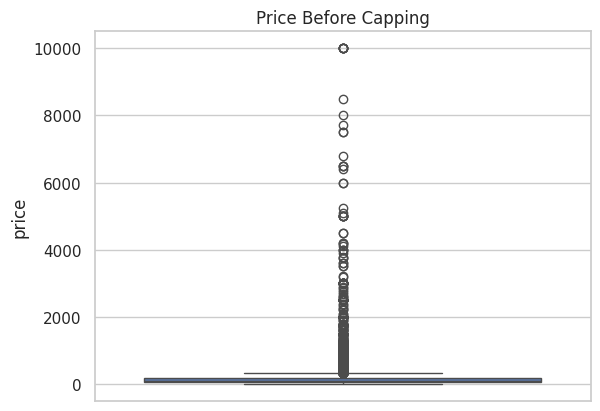

In [136]:
sns.boxplot(data['price'])
plt.title("Price Before Capping")
plt.show()

In [137]:
data = data[data['price'] > 0]

In [138]:
print(data['price'].dtype)       # Should show: float64
print(data['price'].isna().sum())  # Number of invalid prices now marked as NaN

int64
0


In [140]:
print(data['price'].min())
print(data['price'].max())

10
10000


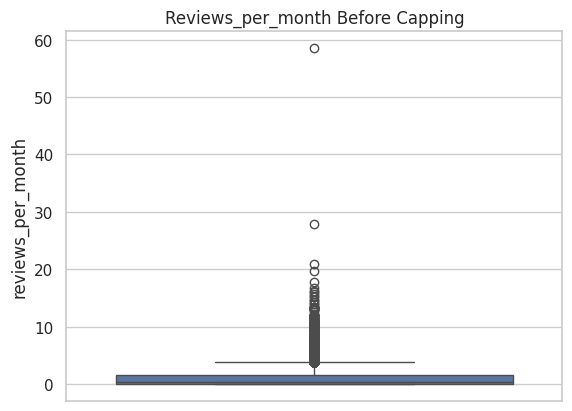

In [141]:
sns.boxplot(data['reviews_per_month'])
plt.title("Reviews_per_month Before Capping")
plt.show()

In [142]:
print("Minimum Nights")
print(data['minimum_nights'].min())
print(data['minimum_nights'].max())
print("Availability 365")
print(data['availability_365'].min())
print(data['availability_365'].max())

Minimum Nights
1
1250
Availability 365
0
365


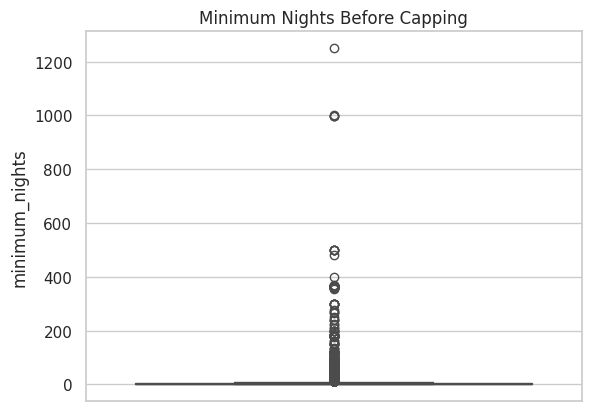

In [143]:
sns.boxplot(data['minimum_nights'])
plt.title("Minimum Nights Before Capping")
plt.show()

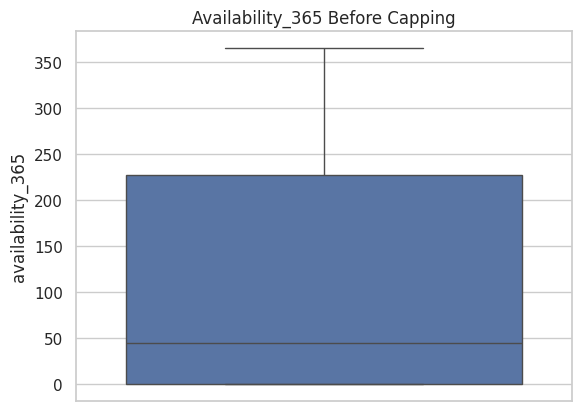

In [144]:
sns.boxplot(data['availability_365'])
plt.title("Availability_365 Before Capping")
plt.show()

**OUTLIERS DETECTION AND CORRECTION**

In [145]:
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

outliers_price = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
print(outliers_price.shape)

Lower bound: -90.0
Upper bound: 334.0
(2972, 15)


In [146]:
#There is upper outliers alone since lowerbound is negative
data['price'] = data['price'].clip(upper=334.0)

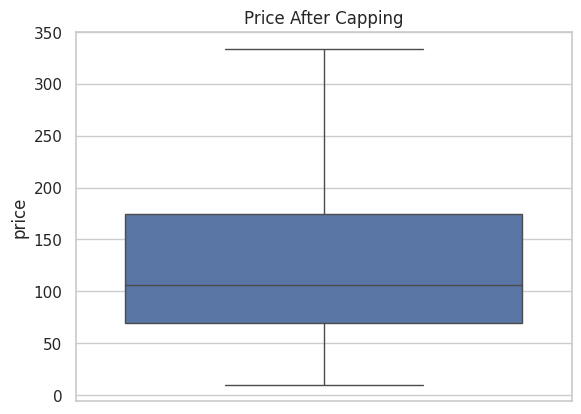

In [147]:
sns.boxplot(data['price'])
plt.title("Price After Capping")
plt.show()

In [148]:
outliers_price = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
print(outliers_price.shape)

(0, 15)


Reviews_per_month

In [149]:
Q1_RPM = data['reviews_per_month'].quantile(0.25)
Q3_RPM = data['reviews_per_month'].quantile(0.75)
IQR_RPM = Q3_RPM - Q1_RPM

lower_bound1 = Q1_RPM - 1.5 * IQR_RPM
upper_bound1 = Q3_RPM + 1.5 * IQR_RPM
print(f"Lower bound: {lower_bound1}")
print(f"Upper bound: {upper_bound1}")

# Find rows that are outliers
outliers_RPM = data[(data['reviews_per_month'] < lower_bound1) | (data['reviews_per_month'] > upper_bound1)]
print("Number of outliers:", outliers_RPM.shape[0])
print(outliers_RPM.shape)

Lower bound: -2.27
Upper bound: 3.89
Number of outliers: 3309
(3309, 15)


In [150]:
data['reviews_per_month'] = data['reviews_per_month'].clip(upper=upper_bound1)

In [151]:
outliers_RPM = data[(data['reviews_per_month'] < lower_bound1) | (data['reviews_per_month'] > upper_bound1)]
print("Number of outliers:", outliers_RPM.shape[0])
print(outliers_RPM.shape)

Number of outliers: 0
(0, 15)


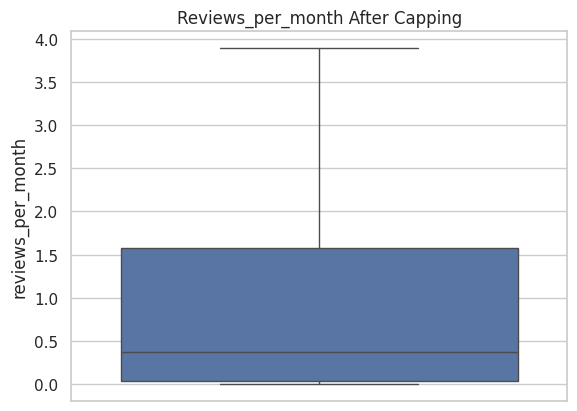

In [152]:
sns.boxplot(data['reviews_per_month'])
plt.title("Reviews_per_month After Capping")
plt.show()

Minimum Nights

In [153]:
# See IQR bounds first
Q1_MN = data['minimum_nights'].quantile(0.25)
Q3_MN = data['minimum_nights'].quantile(0.75)
IQR_MN = Q3_MN - Q1_MN
upper_bound_MN = Q3_MN + 1.5 * IQR_MN

print(f"IQR Upper bound: {upper_bound_MN}")
outliers_MN = data[(data['minimum_nights'] > upper_bound_MN)]
print("Number of outliers:", outliers_MN.shape[0])
print(outliers_MN.shape)

IQR Upper bound: 11.0
Number of outliers: 6605
(6605, 15)


In [154]:
data['minimum_nights'] = data['minimum_nights'].clip(upper=upper_bound_MN)

In [155]:
outliers_MN = data[(data['minimum_nights'] > upper_bound_MN)]
print("Number of outliers:", outliers_MN.shape[0])
print(outliers_MN.shape)

Number of outliers: 0
(0, 15)


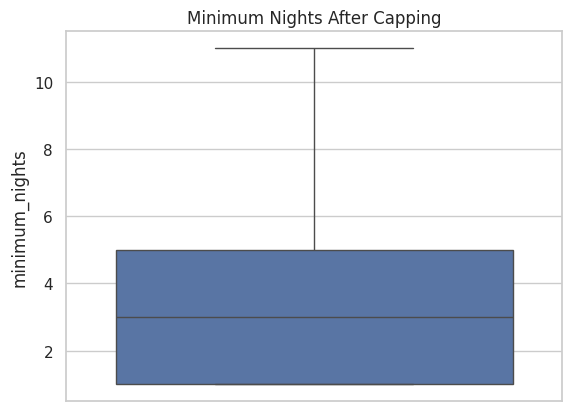

In [156]:
sns.boxplot(data['minimum_nights'])
plt.title("Minimum Nights After Capping")
plt.show()

Availability_365

In [157]:
#Fixing Availability to 0–365 Range
data['availability_365'] = data['availability_365'].clip(lower=0, upper=365)

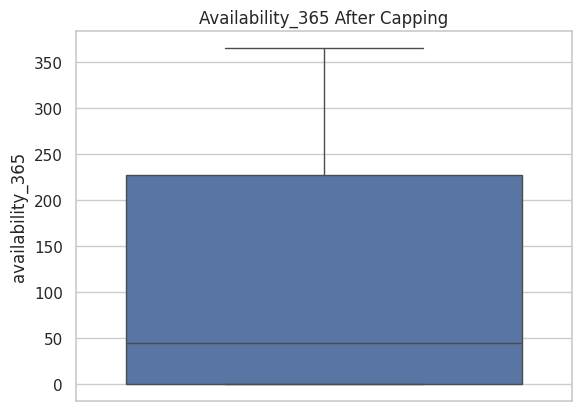

In [158]:
sns.boxplot(data['availability_365'])
plt.title("Availability_365 After Capping")
plt.show()

**RESULT**

In [159]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 48884 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48884 non-null  int64         
 1   host_id                         48884 non-null  int64         
 2   host_name                       48884 non-null  object        
 3   neighbourhood_group             48884 non-null  object        
 4   neighbourhood                   48884 non-null  object        
 5   latitude                        48884 non-null  float64       
 6   longitude                       48884 non-null  float64       
 7   room_type                       48884 non-null  object        
 8   price                           48884 non-null  int64         
 9   minimum_nights                  48884 non-null  int64         
 10  number_of_reviews               48884 non-null  int64         
 11  last_re

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,4.888400e+04,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884,48884.000000,48884.000000,48884.000000
mean,1.901679e+07,6.762203e+07,40.728953,-73.952176,133.009676,3.825301,23.271991,2014-11-25 09:54:30.665248256,0.986473,7.144628,112.779498
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,2000-01-01 00:00:00,0.000000,1.000000,0.000000
25%,9.470548e+06,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,2016-03-24 00:00:00,0.040000,1.000000,0.000000
50%,1.967574e+07,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,2019-01-03 00:00:00,0.370000,1.000000,45.000000
75%,2.915297e+07,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,2019-06-19 00:00:00,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,334.000000,11.000000,629.000000,2019-07-08 00:00:00,3.890000,327.000000,365.000000
std,1.098432e+07,7.861666e+07,0.054532,0.046159,83.516076,3.320666,44.551331,NaN,1.238081,32.956185,131.627271


In [160]:
data.isna().sum()

,0
id,0
host_id,0
host_name,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0


**DASHBOARD**

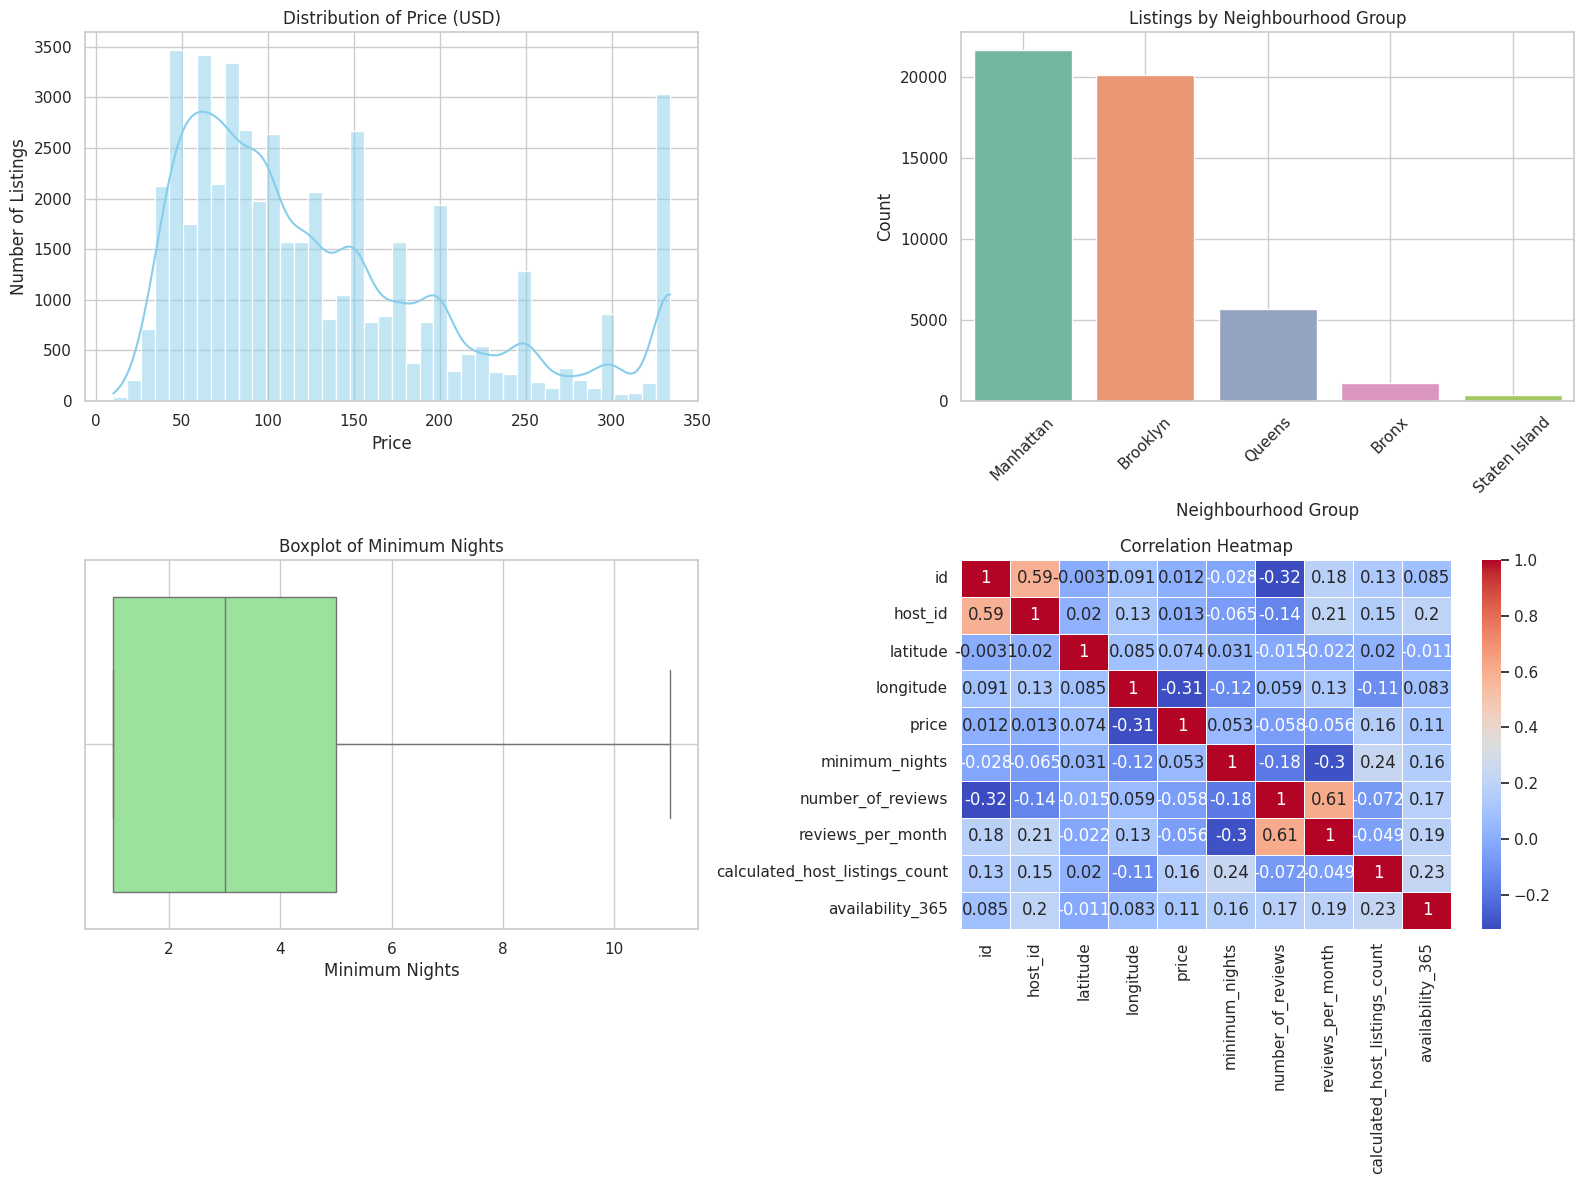

In [161]:
sns.set(style="whitegrid")  # Clean background style

# Set up a 2x2 grid of plots
plt.figure(figsize=(16, 12))

# 1. Histogram of Price
plt.subplot(2, 2, 1)
sns.histplot(data['price'], bins=40, kde=True, color='skyblue')
plt.title("Distribution of Price (USD)")
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.grid(True)

# 2. Countplot of Neighbourhood Group
plt.subplot(2, 2, 2)
sns.countplot(data=data, x='neighbourhood_group',
              order=data['neighbourhood_group'].value_counts().index,
              palette='Set2')
plt.title("Listings by Neighbourhood Group")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)

# 3. Boxplot of Minimum Nights
plt.subplot(2, 2, 3)
sns.boxplot(x=data['minimum_nights'], color='lightgreen')
plt.title("Boxplot of Minimum Nights")
plt.xlabel("Minimum Nights")
plt.grid(True)

# 4. Correlation Heatmap (Numerical Columns)
plt.subplot(2, 2, 4)
numeric_data = data.select_dtypes(include=['int64', 'float64'])
corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()


**Exporting Cleaned Dataset**

In [162]:
data.to_csv("cleaned_airbnb_data.csv", index=False)